<a href="https://colab.research.google.com/github/sugiyama404/ReinfoceLearningForTrading/blob/main/simple_rl_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
from google.colab import drive

from datetime import datetime
from matplotlib import pyplot as plt

drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/reinforcement_learning/'
nov_path = '/content/drive/My Drive/' + nov_dir + 'data_csv_sp500.csv'

df = pd.read_csv(nov_path)
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
class Environment:
    def __init__(self, df, initial_money=1000):

        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_money = initial_money
        self.action_space = np.array([0, 1, 2])
        self.stock_owned = None
        self.now_price = None
        self.cash_in_hand = None

        self.reset()
        
    def reset(self):

        self.end_step = self.df_total_steps
        self.now_step = 0
        self.stock_owned = 0.0
        self.now_price = self.df.loc[self.now_step, 'SP500']
        self.cash_in_hand = self.initial_money

        return self._get_now_state()

    def step(self, action):

        self.now_step += 1
        self.now_price = self.df.loc[self.now_step, 'SP500']
 
        # 含み益
        prev_val = self._get_val()

        done = (self.end_step == self.now_step)

        self._trade(action,done)
        cur_val = self._get_val()
        reward = cur_val - prev_val
        info = {'cur_val': cur_val}

        return self._get_now_state(), reward, done, info

    def _get_now_state(self):
        state = np.empty(3)
        state[0] = self.stock_owned
        state[1] = self.now_price
        state[2] = self.cash_in_hand
        return state

    def _get_val(self):
        return self.stock_owned * self.now_price + self.cash_in_hand

    def _trade(self, action,lastorder = False):
        '''
        0 = sell
        1 = hold
        2 = buy
        売りたい株を売る
        買いたい銘柄を買う
        売買ルール：
        1.空売りは認めない
        2.ポジションを持っている場合、追加注文を出せない。
        3.トレーニング期間は最後のステップでポジションを全て売却する。
        '''
        if lastorder:
            self.cash_in_hand += self.now_price * self.stock_owned
            self.stock_owned = 0
        else:
            if self.action_space[0] == action: # sell
            # 注：問題を簡単にするために、売るときはその株のすべての株を売ることにします
                self.cash_in_hand += self.now_price * self.stock_owned
                self.stock_owned = 0
            if self.action_space[2] == action: # buy
            # 注：購入時には、買いたい銘柄をループさせて、現金がなくなるまで1株ずつ購入していきます。
                buy_flag = True
                while buy_flag:
                    if self.cash_in_hand > self.now_price:
                        self.stock_owned += 1
                        self.cash_in_hand -= self.now_price
                    else:
                        buy_flag = False

In [3]:
def play_episode(env, train_episodes = 50):
    list2 = []
    for episode in range(train_episodes):
        state = env.reset()
        done = False
        start_time = datetime.now()
       
        while not done:
            #乱数で1,2,3を出力
            # action = agent.act(state)
            action = np.random.randint(3, size=1)[0]
            state, reward, done, info = env.step(action)
           
        list2.append(info['cur_val'])
        play_time = datetime.now() - start_time
        # トレード回数、勝率を明記
        print(f"episode: {episode + 1}/{train_episodes}, value: {info['cur_val']:.2f}, duration: {play_time}")
    return list2

episode: 1/10, value: 10311.25, duration: 0:00:00.091730
episode: 2/10, value: 69029.74, duration: 0:00:00.143133
episode: 3/10, value: 155138.51, duration: 0:00:00.125101
episode: 4/10, value: 75097.94, duration: 0:00:00.133523
episode: 5/10, value: 21242.34, duration: 0:00:00.139588
episode: 6/10, value: 14459.74, duration: 0:00:00.133392
episode: 7/10, value: 4549.40, duration: 0:00:00.127250
episode: 8/10, value: 23950.89, duration: 0:00:00.143762
episode: 9/10, value: 68228.07, duration: 0:00:00.077226
episode: 10/10, value: 23869.79, duration: 0:00:00.089957


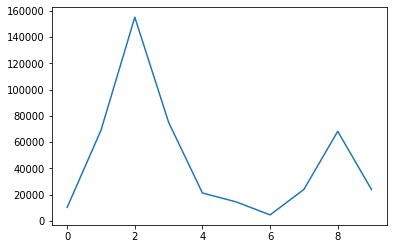

In [4]:
env = Environment(df, initial_money=1000)
#play_episode(env, train_episodes = 10)
list2 = play_episode(env, train_episodes = 10)

x = list(range(10))
y = list2
plt.plot(x, y)
plt.show()